In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import chainer
 
start = dt.date(2011,1,1)
end = dt.date(2018,7,1)

#AMZN:Amazon、AAPL:Apple、GOOGL:Google、ACN:ｱｸｾﾝﾁｭｱ、
#AFL:ｱﾌﾗｯｸ、DIS:ﾃﾞｨｽﾞﾆｰ、FB:Facebook、NVDA:NVIDIA
df_org= web.DataReader('NVDA',"morningstar",start,end)

#翌日のOpen値入力
df_add = df_org['Open'].shift(-1)
#最終日は当日のOpen値入力(これしないとNANになる)
df_add[len(df_org)-1] = df_add[len(df_org)-2] 

#翌日のOpen値入力
df_org = pd.concat([df_org,df_add], axis=1)

#ｶﾗﾑ更新
df_org.columns = ['Close', 'High','Low', 'Open', 'Volume','Open-1']

In [2]:
#時間方向にﾃﾞｰﾀ分割

Num_data = len(df_org)-2
End_N = len(df_org)-1

df = df_org[End_N-Num_data:End_N]

df.tail(10)

Close    High       Low     Open    Volume   Open-1
Symbol Date                                                            
NVDA   2018-06-15  265.26  267.48  263.3484  264.600  10806488  263.480
       2018-06-18  265.09  265.80  262.3800  263.480   8906674  260.920
       2018-06-19  260.17  263.64  255.0200  260.920  14873324  261.832
       2018-06-20  262.31  264.45  260.2808  261.832   9244494  263.600
       2018-06-21  257.11  264.34  256.8000  263.600   8987906  257.950
       2018-06-22  250.95  258.49  250.3301  257.950  10853954  246.650
       2018-06-25  239.12  246.80  235.5400  246.650  16645430  243.700
       2018-06-26  241.99  245.65  239.9101  243.700  11972137  243.750
       2018-06-27  235.72  246.43  235.5000  243.750  11347303  235.320
       2018-06-28  240.86  241.34  235.0100  235.320   8450297  243.490

In [3]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = MinMaxScaler(feature_range=(0, 1))
x2_scaler = MinMaxScaler(feature_range=(0, 1))
x3_scaler = MinMaxScaler(feature_range=(0, 1))
t_scaler = MinMaxScaler(feature_range=(0, 1))
df_x = x_scaler.fit_transform(np.array(df_org['Open-1']).reshape(-1,1)).astype(np.float32)
df_x2 = x2_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)
df_x3 = x3_scaler.fit_transform(np.array(df_org['High']).reshape(-1,1)).astype(np.float32)
df_t = t_scaler.fit_transform(np.array(df_org['Close']).reshape(-1,1)).astype(np.float32)


In [4]:

#訓練データと教師データへの分割

x,x2,x3,t = [],[],[],[]
 
N = len(df_org)
M = 30
for n in range(M,N):
    _x = df_x[n-M:n]
    _x2 = df_x2[n-M:n]
    _x3 = df_x3[n-M:n]
    _t = df_t[n]
    x.append(_x)
    x2.append(_x2)
    x3.append(_x3)
    t.append(_t)

#trainﾃﾞｰﾀの割合
ratio_train_test = 0.8
#testﾃﾞｰﾀの個数
n_test = 30
#testﾃﾞｰﾀ数を個数で決めるか割合で決めるかのSW
SW = -1

#例：x[1]は初日からM日分の(標準化された)Closeﾃﾞｰﾀ、t[1]はM+1日目のCloseﾃﾞｰﾀ
x = np.array(x, dtype = np.float32)
x2 = np.array(x2, dtype = np.float32)
x3 = np.array(x3, dtype = np.float32)
t = np.array(t, dtype = np.float32).reshape(len(t),1)

x = np.c_[x,x2]

if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass

dataset = list(zip(x, t))
train, test = chainer.datasets.split_dataset(dataset,n_train)

In [5]:
# chainerと必要なパッケージをインポート
import chainer.links as L
import chainer.functions as F
from chainer import Chain, Variable, datasets, optimizers
from chainer import report, training
from chainer.training import extensions
import chainer.cuda

# ニューラルネットワークモデルを作成
class RNN(Chain):
    def __init__(self, n_units, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.LSTM(None, n_units)
            self.l2 = L.Linear(None, n_output)
        
    def reset_state(self):
        self.l1.reset_state()

        
    def __call__(self, x, t):
        y = self.predict(x)
        loss = F.mean_squared_error(y, t)
        report({'loss':loss},self)
        return loss
        
    def predict(self, x):
        #if train:
            #h1 = F.dropout(self.l1(x),ratio = 0.5)
        #else:
        h1 = self.l1(x)
        return self.l2(h1)

## LSTMUpdaterを作る。
class LSTMUpdater(training.StandardUpdater):
    def __init__(self, data_iter, optimizer, device=None):
        super(LSTMUpdater,self).__init__(data_iter, optimizer, device=None)
        self.device = device
        
    def update_core(self):
        data_iter = self.get_iterator("main")
        optimizer = self.get_optimizer("main")
        
        batch = data_iter.__next__()
        x_batch, t_batch = chainer.dataset.concat_examples(batch, self.device)
        
        optimizer.target.reset_state()           #追加
        optimizer.target.cleargrads()
        loss = optimizer.target(x_batch, t_batch)
        loss.backward()
        loss.unchain_backward()                  #追記
        optimizer.update() 

print("step done")

step done


In [6]:
# 乱数のシードを固定 (再現性の確保)
np.random.seed(1)
 
# モデルの宣言
model = RNN(30, 1)
 
# GPU対応
#chainer.cuda.get_device(0).use()
#model.to_gpu()                 
 
# Optimizer
optimizer = optimizers.Adam()
optimizer.setup(model)
 
# Iterator
batchsize = 20 #ﾐﾆﾊﾞｯﾁのｻｲｽﾞ
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
 
# Updater &lt;- LSTM用にカスタマイズ
updater = LSTMUpdater(train_iter, optimizer,device = -1)
 
# Trainerとそのextensions
epoch = 200
trainer = training.Trainer(updater, (epoch, 'epoch'), out='result')
 
# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model,device = -1))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
 
# １エポックごとに、trainデータに対するlossと、testデータに対するlossを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

print("step done")

step done


In [7]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           0.00518733  0.0877601             0.244379      
2           0.000616066  0.100829              0.486608      
3           0.000544398  0.0818435             0.737775      
4           0.000445012  0.07478               0.978124      
5           0.000391894  0.0800084             1.2734        
6           0.000328783  0.0921953             1.5777        
7           0.000279047  0.0746035             1.84682       
8           0.00037987  0.103932              2.09306       
9           0.000224299  0.0823292             2.34903       
10          0.000242896  0.101725              2.61322       
11          0.000269224  0.126914              2.89164       
12          0.000228119  0.0724131             3.15102       
13          0.000186739  0.0688716             3.41326       
14          0.000196447  0.109558              3.64538       
15          0.000175639  0.0978509             3.94373       
16          0

133         0.000152124  0.071527              38.1419       
134         0.000126655  0.0688383             38.405        
135         8.75987e-05  0.0542161             38.6755       
136         0.0001556   0.0504424             38.9339       
137         9.00036e-05  0.0503039             39.1977       
138         8.57598e-05  0.0564032             39.4867       
139         7.59488e-05  0.055713              39.7959       
140         7.53333e-05  0.0767976             40.0683       
141         7.67628e-05  0.0899673             40.3979       
142         9.44319e-05  0.0689782             40.8065       
143         7.53157e-05  0.0806901             41.0707       
144         6.87278e-05  0.0689075             41.3261       
145         7.30754e-05  0.0835509             41.6004       
146         0.000105567  0.0760859             41.8746       
147         7.30152e-05  0.0770453             42.1406       
148         7.73381e-05  0.0674263             42.4132       
149      

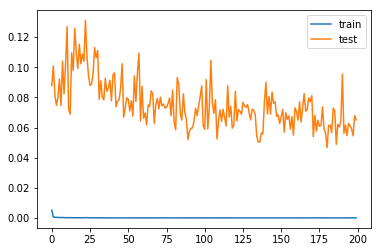

In [8]:
# 結果を読み込み
import json
with open('result/log') as f:
     logs = json.load(f)
 
# 結果を整理
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]
 
# プロット
plt.plot(loss_train, label='train')
plt.plot(loss_test,  label='test')
plt.legend()
plt.show()

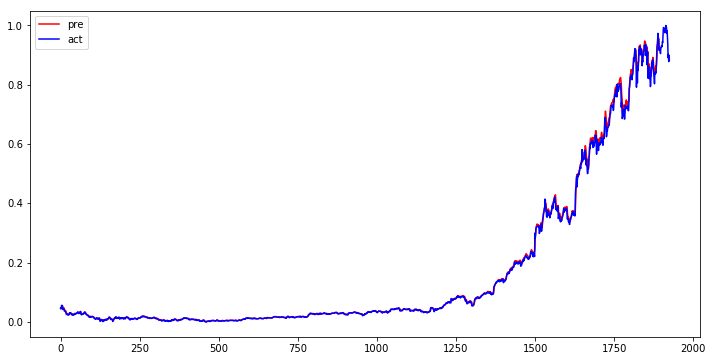

In [9]:
# 訓練：90%, 検証：10%で分割する
if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass


train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# 訓練データ
model.reset_state()
train_y = model.predict(Variable(train_x)).data# 訓練：90%, 検証：10%でランダムに分割する

n_train = int(len(x) * 1)
train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# プロット
plt.figure(figsize=(12,6))
 
plt.plot(train_y,label = 'pre', color='red')   # 予測値
plt.plot(train_t, label = 'act', color='blue')  # 実測値
plt.legend()
plt.show()

<class 'numpy.ndarray'>


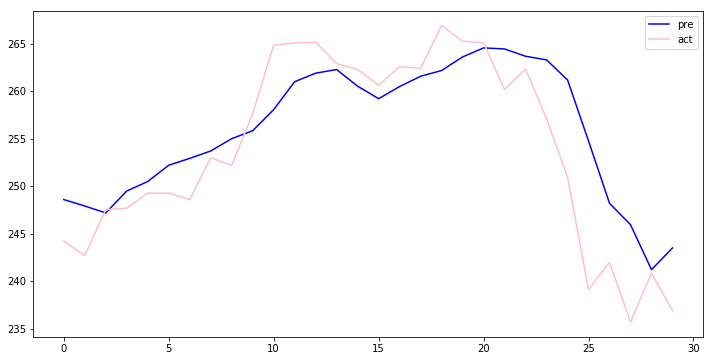

勝率=58.621％


In [10]:
if SW == 1:
    n_train = int(len(x) * ratio_train_test)
elif SW == -1:
    n_train = len(x)-n_test
else:
    pass

train_x, test_x = x[:n_train], x[n_train:]
train_t, test_t = t[:n_train], t[n_train:]

# 検証データ
model.reset_state()
test_y = model.predict(Variable(test_x)).data

print(type(test_x))

test_y = t_scaler.inverse_transform(test_y)
test_t = t_scaler.inverse_transform(test_t)

#予測値の移動平均を計算
num = 5
b = np.ones(num)/num
ave_test_y=np.convolve(test_y[:,0], b, mode='same')
    
# プロット
plt.figure(figsize=(12,6))
 
plt.plot(test_y,label = 'pre', color='blue')   # 予測値
plt.plot(test_t,label = 'act', color='pink')  # 実測値
#plt.plot(ave_test_y,label = 'pre_ave', color='red') #移動平均予測
plt.legend()
plt.show()

updown_y = []
updown_t =[]
score = 0

for i in range(len(test_t)-1):
    if test_t[i+1]>test_t[i]:
        updown_t.append(1)
    else:
        updown_t.append(-1)
    if test_y[i+1]>test_y[i]:
        updown_y.append(1)
    else:
        updown_y.append(-1)
    
    if updown_t[i] == updown_y[i]:
        score = score + 1
    else:
        pass

score = score/len(updown_t)*100
print('勝率=%.3f％'%score)

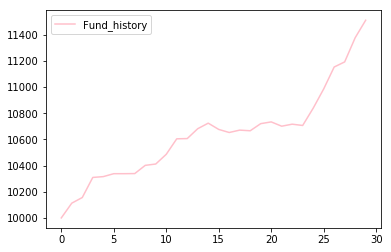

In [11]:
###資産運用SIM

#ﾃｽﾄ期間
Period = len(test_t)

df_open = df['Open'][len(df)-Period:len(df)]
df_close = df['Close'][len(df)-Period:len(df)]

#元金
Fund = 10000 #[ﾄﾞﾙ]
Investment = 0 #投資額/日
stock_num = 0 #購入株数/日
charge = 0 #手数料
ratio_inv = 0.5
Fund_his = []

Fund_his.append(Fund)

#株売買ｼﾐｭﾚｰｼｮﾝ
for i in range(Period-1):
    if updown_y[i] ==1:
        Investment = ratio_inv*Fund
        Fund = Fund - Investment
        stock_num = Investment/df_open[i+1] #Open値
        Fund = Fund + stock_num*df_close[i+1]-charge #Close値
    if updown_y[i] == -1:
        Investment = ratio_inv*Fund
        Fund = Fund + Investment
        stock_num = Investment/df_open[i+1]
        Fund = Fund - stock_num*df_close[i+1]-charge
    Fund_his.append(Fund)

plt.plot(Fund_his,label = 'Fund_history', color='pink')  # 実測値
plt.legend()
plt.show()